# **MACHINE LEARNING**
---

## **IMPORT**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## **ĐỌC DỮ LIỆU**

In [2]:
df = pd.read_csv('../Data/movie_data.csv')
df.head(5)

,Title,Release time,Age rating,Runtime,Language,IMDb Rating,IMDb Votes,Action/Adventure,Animation,Biography/History/War,...,Drama,Fantasy/Sci-Fi,Horror/Thriller/Mystery,Kids/Family,Music/Musical,Other,Romance,Win,Nomination,Age rating quantification
0,Goon Squad,2024-01-18,NC-17,83.0,English,6.1,12398.815824,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,5
1,The Phantom Warrior,2024-02-20,R,83.0,English,2.6,532.000000,True,False,False,...,False,True,False,False,False,False,False,0.0,0.0,4
2,Beyond the Lake,2024-01-26,G,98.0,English,6.1,31.000000,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,1
3,Crimes of Fashion: Killer Clutch,2024-03-15,PG,84.0,"English, French",5.8,503.000000,False,False,False,...,True,False,True,False,False,False,False,0.0,0.0,2
4,Love on the Danube: Love Song,2024-09-10,G,84.0,English,5.8,175.000000,False,False,False,...,False,False,False,False,False,False,True,0.0,0.0,1


## **Mô hình RandomForestRegressor**

In [3]:
# Load dữ liệu
df = pd.read_csv('../Data/movie_data.csv')  # Thay bằng đường dẫn thật

# Tiền xử lý dữ liệu
# Trích xuất các thuộc tính từ 'Release time'
df['Release time'] = pd.to_datetime(df['Release time'])
df['Release Year'] = df['Release time'].dt.year
df['Release Month'] = df['Release time'].dt.month
df['Release Day'] = df['Release time'].dt.day
df['Release Weekday'] = df['Release time'].dt.weekday  # 0 = Monday, 6 = Sunday
df = df.drop(columns=["Release time"])  # Xóa cột 'Release time' gốc nếu không cần thiết

# Input và Output
X = df.drop(columns=["Title", "IMDb Rating", "IMDb Votes", "Win", "Nomination"])  # Input
y = df[["IMDb Rating", "IMDb Votes"]]  # Output

# Cột phân loại
categorical_columns = ["Language", "Age rating"]

# Tiền xử lý cho các cột phân loại và số
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_columns),
        ("num", StandardScaler(), ["Release Year", "Release Month", "Release Day", "Release Weekday"] + [col for col in X.columns if col not in categorical_columns])
    ]
)

# Áp dụng tiền xử lý
X_preprocessed = preprocessor.fit_transform(X)

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Mô hình 1: MultiOutputRegressor với Linear Regression
linear_model = MultiOutputRegressor(LinearRegression())
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Mô hình 2: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Đánh giá mô hình
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred, multioutput="raw_values")
    mse = mean_squared_error(y_true, y_pred, multioutput="raw_values")
    r2 = r2_score(y_true, y_pred, multioutput="raw_values")
    print(f"\nModel: {model_name}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2: {r2}")
    return mae, mse, r2

# Đánh giá Linear Regression
mae_linear, mse_linear, r2_linear = evaluate_model(y_test, y_pred_linear, "Linear Regression")

# Đánh giá Random Forest
mae_rf, mse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")


Model: Linear Regression
MAE: [7.46210708e-01 1.69411066e+04]
MSE: [1.01732092e+00 9.17103396e+08]
R2: [0.25124364 0.00695712]

Model: Random Forest
MAE: [7.46376930e-01 1.33717577e+04]
MSE: [1.12485871e+00 9.08637041e+08]
R2: [0.17209496 0.01612452]


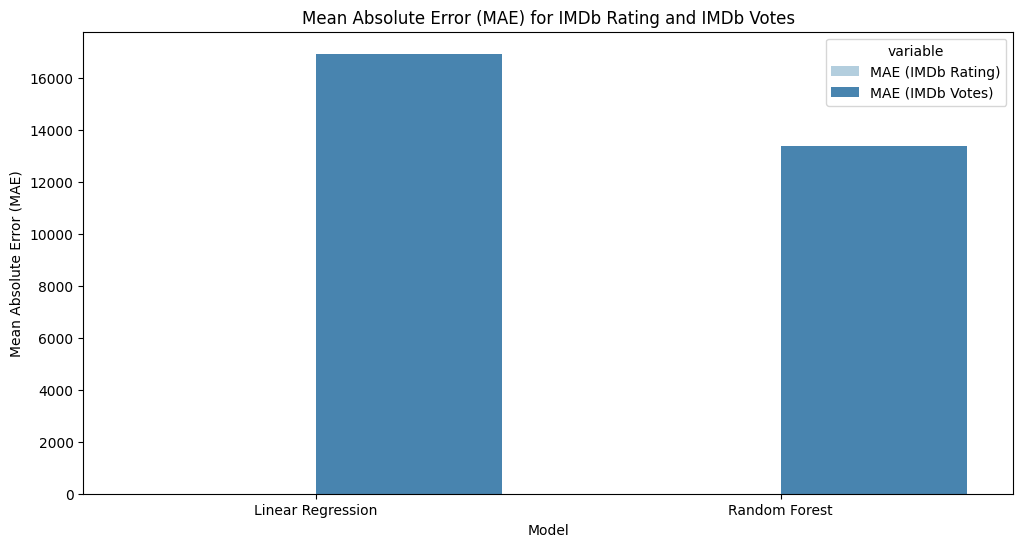

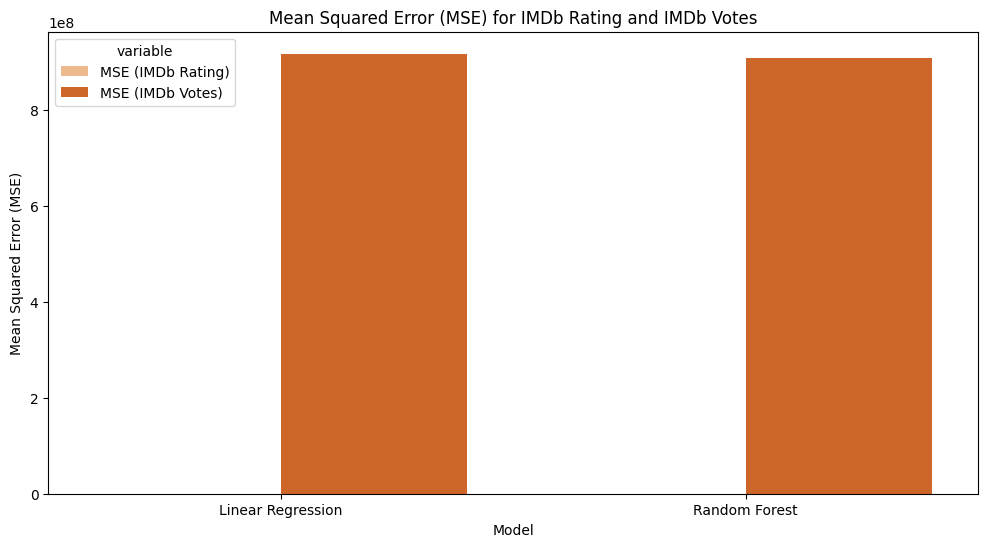

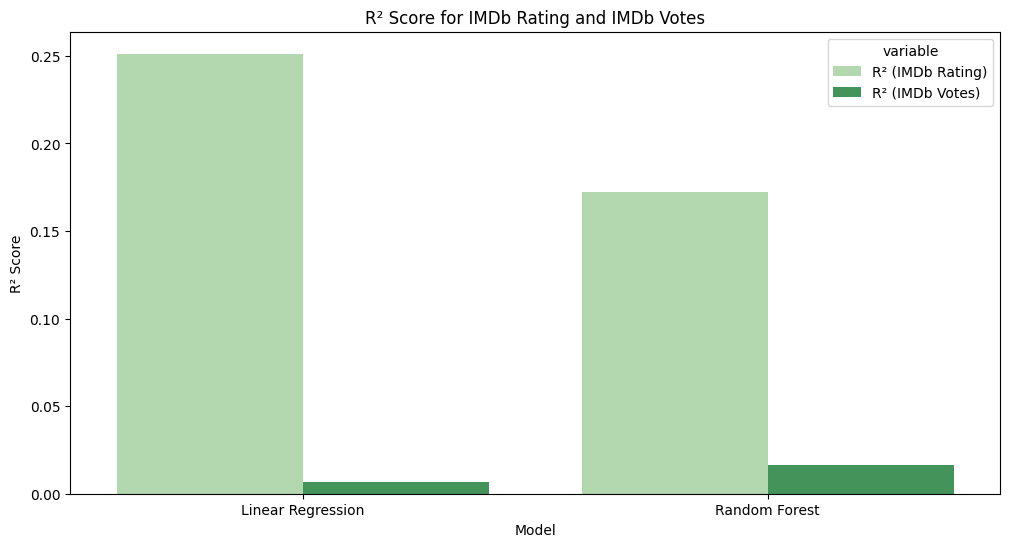

In [4]:
# Tạo DataFrame chứa các kết quả
results = {
    "Model": ["Linear Regression", "Random Forest"],
    "MAE (IMDb Rating)": [mae_linear[0], mae_rf[0]],
    "MAE (IMDb Votes)": [mae_linear[1], mae_rf[1]],
    "MSE (IMDb Rating)": [mse_linear[0], mse_rf[0]],
    "MSE (IMDb Votes)": [mse_linear[1], mse_rf[1]],
    "R² (IMDb Rating)": [r2_linear[0], r2_rf[0]],
    "R² (IMDb Votes)": [r2_linear[1], r2_rf[1]]
}

# Chuyển đổi kết quả thành DataFrame để dễ dàng trực quan hóa
results_df = pd.DataFrame(results)

# Vẽ biểu đồ MAE
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="value", hue="variable", data=pd.melt(results_df, id_vars=["Model"], value_vars=["MAE (IMDb Rating)", "MAE (IMDb Votes)"]), palette="Blues")
plt.title("Mean Absolute Error (MAE) for IMDb Rating and IMDb Votes")
plt.ylabel("Mean Absolute Error (MAE)")
plt.show()

# Vẽ biểu đồ MSE
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="value", hue="variable", data=pd.melt(results_df, id_vars=["Model"], value_vars=["MSE (IMDb Rating)", "MSE (IMDb Votes)"]), palette="Oranges")
plt.title("Mean Squared Error (MSE) for IMDb Rating and IMDb Votes")
plt.ylabel("Mean Squared Error (MSE)")
plt.show()

# Vẽ biểu đồ R²
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="value", hue="variable", data=pd.melt(results_df, id_vars=["Model"], value_vars=["R² (IMDb Rating)", "R² (IMDb Votes)"]), palette="Greens")
plt.title("R² Score for IMDb Rating and IMDb Votes")
plt.ylabel("R² Score")
plt.show()
